In [298]:
import numpy as np
print(np.__version__) 
import matplotlib.pyplot as plt 
import scipy.integrate as integrate 
from scipy.integrate import odeint 
import time
from IPython import display 
from matplotlib.patches import Patch 
from matplotlib.lines import Line2D 
import os 
plt.rcParams['axes.titlesize'] = 22 
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 18 
plt.rcParams['axes.titlepad'] = 20 
plt.rcParams['axes.labelpad'] = 16

1.16.4


In [339]:
C_bounds

array([-4., -1.])

In [299]:
#First set the number of models:
models = 3000

#Now choose parameters randomly (within the allowed bounds) for each model
#For carbon, we have 4 parameters: total carbon, temperature, oxidation state, pH

#Set boundaries:
C_bounds = np.log10([1e-4,1e-1]) #0.1 - 100 mmol
T_bounds = [1,500]
aH2_bounds = [-2,2] #about FMQ for a given temperature
pH_bounds = [-2,4] #about pH neutral for a given temperature

#Import values for aH2 at FMQ and pH neutral at each temp:
N, T_Kw, P, log_Kw = np.loadtxt('Europa_K/Kw_1500bar.txt', skiprows=8, unpack=True)
pH_neutral = -0.5*log_Kw #function of T

#The FMQ buffer: 1.5Fe2SiO4 + H2O → Fe3O4 + 1.5SiO2 + H2
#logK = log(aH2) (all other activities are 1)
N, T_FMQ, P, logK_FMQ = np.loadtxt('Europa_K/FMQ_1500bar.txt', skiprows=10, unpack=True)
aH2_FMQ = logK_FMQ

#Choose values at random for total carbon & temperature:
sigma_C = np.zeros(models)
T = np.zeros(models)
indices = list() #for getting appropriate aH2=FMQ & pH neutral values at each temp
aH2_rel = np.zeros(models)
aH2 = np.zeros(models) #so we get the absolute value as well as the value about FMQ
pH_rel = np.zeros(models)
pH = np.zeros(models) #so we get the absolute value as well as the value about pH neutral

for i in range(0,models):
    sigma_C[i] = np.random.uniform(C_bounds[0],C_bounds[1])
    T[i] = np.random.randint(T_bounds[0], T_bounds[1]+1) #choose random integers
    #number formatting correction
    indices.append(int(T[i]))
    aH2_rel[i] = np.random.uniform(aH2_bounds[0],aH2_bounds[1]) #about FMQ
    #aH2 = log aH2 at FMQ +/- chosen log units
    aH2[i] = aH2_FMQ[indices[i]] + aH2_rel[i]
    #same deal for pH
    pH_rel[i] = np.random.uniform(pH_bounds[0],pH_bounds[1]) #about pH neutral - still need to calculate actual value
    #pH = pH neutral +/i chosen log units
    pH[i] = pH_neutral[indices[i]] + pH_rel[i]
    #np.random.uniform(low=0.0, high=6.0, size=None)
 

In [346]:
#We have:
#SigmaC = CH4 + CO2 +  HCO3- + CO3-2 + CO + HCOOH + HCOO- + H2CO3 + 2C2H6 + 3C3H8 + 4C4H10
#Which yields the polynomial:
#A[CH4]^4 + B[CH4]^3 + C[CH4]^2 + D[CH4] + E

CH4 = np.zeros(models)
CO2 = np.zeros(models)
HCO3 = np.zeros(models)
CO3 = np.zeros(models)
CO = np.zeros(models)
HCOOH = np.zeros(models)
HCOO = np.zeros(models)
H2CO3 = np.zeros(models)
C2H6 = np.zeros(models)
C3H8 = np.zeros(models)
C4H10 = np.zeros(models)

#Now let's calculate the coefficients:
E = -(10**sigma_C)
    
#calculate speciation for each model - ONE value for each volatile per model
for i in range(0,models):
    A = 4*(10**K_C4H10[indices[i]])/(10**aH2[i])
    B = 3*(10**K_C3H8[indices[i]])/(10**aH2[i])
    C = 2*(10**K_C2H6[indices[i]])/(10**aH2[i])
    D = 1 + (10**K_CO2[indices[i]])/((10**aH2[i])**4) + (10**K_HCO3[indices[i]])/((10**-pH[i])*(10**aH2[i])**4) + (10**K_CO3[indices[i]])/(((10**-pH[i])**2)*(10**aH2[i])**4) + (10**K_CO[indices[i]])/((10**aH2[i])**3) + (10**K_HCOOH[indices[i]])/((10**aH2[i])**3) + (10**K_HCOO[indices[i]])/((10**-pH[i])*(10**aH2[i])**3) + (10**K_H2CO3[indices[i]])/((10**aH2[i])**4) 
    #Solve the polynomial for [CH4]:
    p = np.array([A,B,C,D,E[i]])
    r = np.roots(p)
    real_r = r[np.isreal(r)]
    CH4[i] = real_r[1]

#Now get the other concentrations:
CO2 = CH4*(10**K_CO2[indices])/((10**aH2)**4)
HCO3 = CH4*(10**K_HCO3[indices])/((10**-pH)*(10**aH2)**4)
CO3 = CH4*(10**K_CO3[indices])/(((10**-pH)**2)*(10**aH2)**4)
CO = CH4*(10**K_CO[indices])/((10**aH2)**3)
HCOOH = CH4*(10**K_HCOOH[indices])/((10**aH2)**3)
HCOO = CH4*(10**K_HCOO[indices])/((10**-pH)*(10**aH2)**3)
H2CO3 = CH4*(10**K_H2CO3[indices])/((10**aH2)**4)
C2H6 = (CH4**2)*(10**K_C2H6[indices])/(10**aH2)
C3H8 = (CH4**3)*(10**K_C3H8[indices])/(10**aH2)
C4H10 = (CH4**4)*(10**K_C2H6[indices])/(10**aH2)


/Users/cray/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


In [348]:
CH4

array([3.13713346e-03, 1.68802812e-07, 2.47296938e-03, ...,
       8.62001728e-02, 3.90756762e-02, 2.59403909e-03])

In [398]:
#Now make a triangle plot with the results
C_lim = (C_bounds[0]-0.1, C_bounds[1]+0.1)
C_ticks = np.log10((1e-4, 1e-3, 1e-2, 1e-1)*1000) #mmol
C_labels = ('-1', '0', '1', '2')

T_lim = (T_bounds[0]-50, T_bounds[1]+50)
T_ticks = (50, 150, 250, 350, 450)
T_labels = ('50', '150', '250', '350', '450')

#aH2 relative to FMQ:
aH2_lim = (-2.5, 2.5)
aH2_ticks = (-2, -1, 0, 1, 2)
aH2_labels = ('-2', '-1', '0', '1', '2')

#aH2 actual values:
# aH2_lim = (-8, 1)
# aH2_ticks = (-7, -5, -3, -1)
# aH2_labels = ('-7', '-5', '-3', '-1')

#pH relative to FMQ:
pH_lim = (-2.5, 4.5)
pH_ticks = (-2, 0, 2, 4)
pH_labels = ('-2', '0', '2', '4')

#pH actual values:
# pH_lim = (2, 12)
# pH_ticks = (3, 6, 9, 12)
# pH_labels = ('3', '6', '9', '12')


#labels = ['log[$\Sigma$C] (mmol)', 'T (C)', 'aH$_2$ \n(log units from FMQ)', 'pH \n(log units from neutral)', ]
labels = ['log[$\Sigma$C] \n (mmol\kg H$_2$O)', 'T (C)', 'log(a$_{H_2}$) \n (kg/mol H$_2$O)', 'pH', ]

#for normalizing histograms:
def weight(array):
    weight = np.ones_like(array)/float(len(array))
    return weight



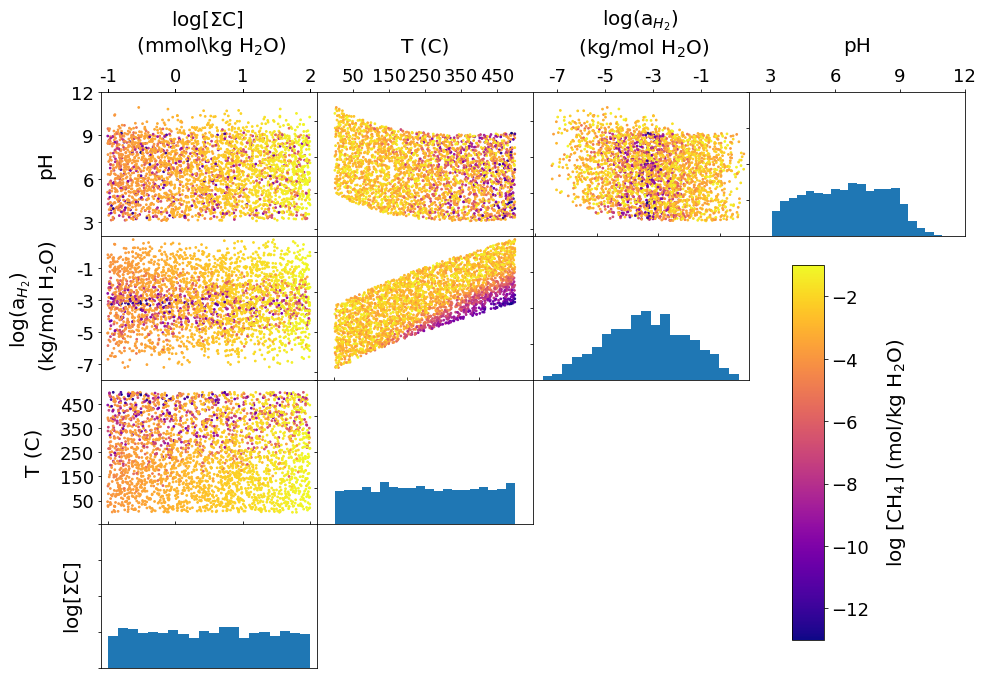

In [361]:
fig = plt.figure(1)

#First row
ax = plt.subplot(4,4,1)
plt.scatter(sigma_C, pH_rel,  s = 12.0, marker = '.', c = np.log10(CH4), cmap = 'plasma')
#plt.scatter(sigma_C, pH, s = 12.0, marker = '.', c = np.log10(CH4), cmap = 'plasma')
plt.xlabel(labels[0])
plt.ylabel(labels[-1])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(C_ticks, C_labels)
plt.xlim(C_lim)
plt.yticks(pH_ticks, pH_labels)
plt.ylim(pH_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
plt.clim(-13,-1)

ax = plt.subplot(4,4,2)
plt.scatter(T, pH_rel,  s = 12.0, marker = '.', c = np.log10(CH4), cmap = 'plasma')
#plt.scatter(T, pH, s = 12.0, marker = '.', c = np.log10(CH4), cmap = 'plasma')
plt.xlabel(labels[1])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(T_ticks, T_labels)
plt.xlim(T_lim)
plt.ylim(pH_lim)
plt.clim(-13,-1)

ax = plt.subplot(4,4,3)
plt.scatter(aH2_rel, pH_rel, 'k.', markersize = 5.0)
#plt.scatter(aH2, pH, s = 12.0, marker = '.', c = np.log10(CH4), cmap = 'plasma')
plt.xlabel(labels[2])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(aH2_ticks, aH2_labels)
plt.xlim(aH2_lim)
plt.ylim(pH_lim)
plt.clim(-13,-1)

ax = plt.subplot(4,4,4)
#plt.hist(pH_rel, bins = 10, weights=weight(pH))
plt.hist(pH, bins = 20, weights=weight(pH))
plt.xlabel(labels[3])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xlim(pH_lim)
plt.xticks(pH_ticks, pH_labels)
plt.ylim(0,0.2)

#Second Row
ax = plt.subplot(4,4,5)
#plt.plot(sigma_C, aH2_rel, 'k.', markersize = 5.0)
plt.scatter(sigma_C, aH2, s = 12.0, marker = '.', c = np.log10(CH4), cmap = 'plasma')
plt.ylabel(labels[-2])
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(C_lim)
plt.yticks(aH2_ticks, aH2_labels)
plt.ylim(aH2_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
plt.clim(-13,-1)

ax = plt.subplot(4,4,6)
#plt.plot(T, aH2_rel, 'k.', markersize = 5.0)
plt.scatter(T, aH2, s = 12.0, marker = '.', c = np.log10(CH4), cmap = 'plasma')
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(T_lim)
plt.ylim(aH2_lim)
plt.clim(-13,-1)

ax = plt.subplot(4,4,7)
plt.hist(aH2, bins = 20, weights=weight(aH2_rel))
#plt.hist(aH2, bins = 20, weights=weight(aH2))
ax.xaxis.tick_top()
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
#plt.xlim(aH2_lim)
plt.ylim(0,0.2)

#Third Row
ax = plt.subplot(4,4,9)
plt.scatter(sigma_C, T, s = 12.0, marker = '.', c = np.log10(CH4), cmap = 'plasma')
plt.ylabel(labels[-3])
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(C_lim)
plt.yticks(T_ticks, T_labels)
plt.ylim(T_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
plt.clim(-13,-1)

ax = plt.subplot(4,4,10)
plt.hist(T, bins = 20, weights=weight(T))
ax.xaxis.tick_top()
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(T_lim)
plt.ylim(0,0.2)

#Fourth Row
ax = plt.subplot(4,4,13)
plt.hist(sigma_C, bins = 20, weights=weight(sigma_C))
ax.xaxis.tick_top()
plt.ylabel('log[$\Sigma$C]')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.ylim(0,0.2)
plt.xlim(C_lim)

#Adjust spacing in subloglogs
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0.00, hspace=0.00)

left  = 0.125  # the left side xof the subloglogs of the figure
right = 0.9    # the right side of the subloglogs of the figure
bottom = 0.1   # the bottom of the subloglogs of the figure
top = 0.9      # the top of the subloglogs of the figure
wspace = 0.2   # the amount of width reserved for blank space between subloglogs
hspace = 0.5   # the amount of height reserved for white space between subloglogs

cbar_ax = fig.add_axes([1.6, 0.1, 0.075, 1.3])
plt.colorbar(cax = cbar_ax, label='log [CH$_4$] (mol/kg H$_2$O)')
#plt.clim(-4,0)
plt.savefig('Pyramids/CH4.png', bbox_inches = 'tight')

In [353]:
np.min(np.log10(CH4))

-13.323612579784747

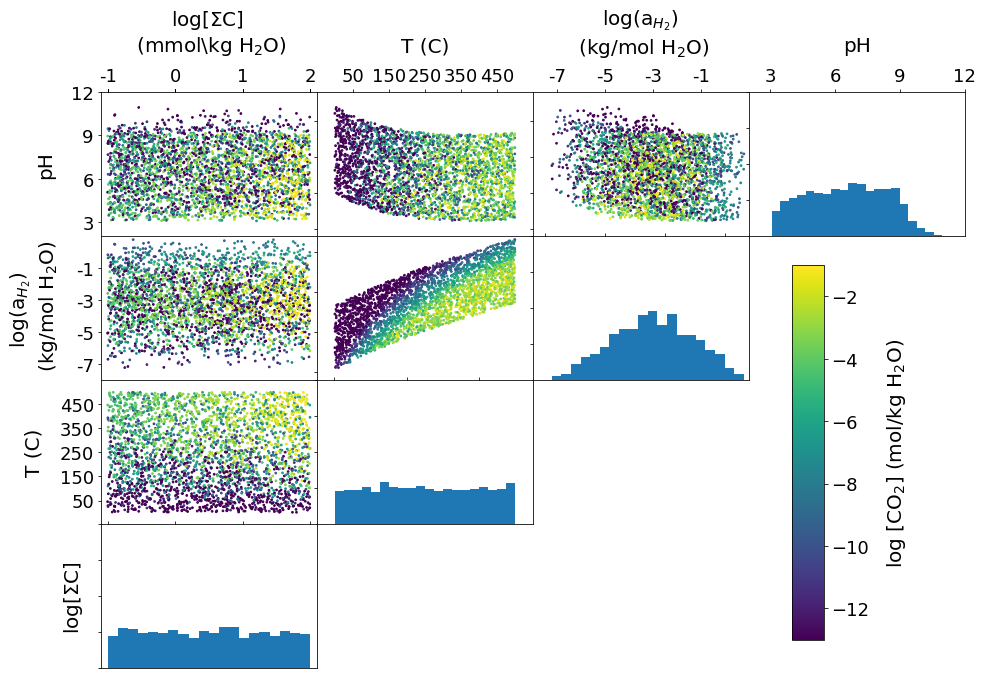

In [360]:
fig = plt.figure(2)

#First row
ax = plt.subplot(4,4,1)
#plt.plot(sigma_C, pH_rel, 'k.', markersize = 5.0)
plt.scatter(sigma_C, pH, s = 12.0, marker = '.', c = np.log10(CO2), cmap = 'viridis')
plt.xlabel(labels[0])
plt.ylabel(labels[-1])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(C_ticks, C_labels)
plt.xlim(C_lim)
plt.yticks(pH_ticks, pH_labels)
plt.ylim(pH_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
plt.clim(-13,-1)

ax = plt.subplot(4,4,2)
#plt.plot(T, pH_rel, 'k.', markersize = 5.0)
plt.scatter(T, pH, s = 12.0, marker = '.', c = np.log10(CO2), cmap = 'viridis')
plt.xlabel(labels[1])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(T_ticks, T_labels)
plt.xlim(T_lim)
plt.ylim(pH_lim)
plt.clim(-13,-1)

ax = plt.subplot(4,4,3)
#plt.plot(aH2_rel, pH_rel, 'k.', markersize = 5.0)
plt.scatter(aH2, pH, s = 12.0, marker = '.', c = np.log10(CO2), cmap = 'viridis')
plt.xlabel(labels[2])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(aH2_ticks, aH2_labels)
plt.xlim(aH2_lim)
plt.ylim(pH_lim)
plt.clim(-13,-1)

ax = plt.subplot(4,4,4)
#plt.hist(pH_rel, bins = 10, weights=weight(pH))
plt.hist(pH, bins = 20, weights=weight(pH))
plt.xlabel(labels[3])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xlim(pH_lim)
plt.xticks(pH_ticks, pH_labels)
plt.ylim(0,0.2)

#Second Row
ax = plt.subplot(4,4,5)
#plt.plot(sigma_C, aH2_rel, 'k.', markersize = 5.0)
plt.scatter(sigma_C, aH2, s = 12.0, marker = '.', c = np.log10(CO2), cmap = 'viridis')
plt.ylabel(labels[-2])
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(C_lim)
plt.yticks(aH2_ticks, aH2_labels)
plt.ylim(aH2_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
plt.clim(-13,-1)

ax = plt.subplot(4,4,6)
#plt.plot(T, aH2_rel, 'k.', markersize = 5.0)
plt.scatter(T, aH2, s = 12.0, marker = '.', c = np.log10(CO2), cmap = 'viridis')
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(T_lim)
plt.ylim(aH2_lim)
plt.clim(-13,-1)

ax = plt.subplot(4,4,7)
#plt.hist(aH2_rel, bins = 10, weights=weight(aH2))
plt.hist(aH2, bins = 20, weights=weight(aH2))
ax.xaxis.tick_top()
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(aH2_lim)
plt.ylim(0,0.2)

#Third Row
ax = plt.subplot(4,4,9)
plt.scatter(sigma_C, T, s = 12.0, marker = '.', c = np.log10(CO2), cmap = 'viridis')
plt.ylabel(labels[-3])
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(C_lim)
plt.yticks(T_ticks, T_labels)
plt.ylim(T_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
plt.clim(-13,-1)

ax = plt.subplot(4,4,10)
plt.hist(T, bins = 20, weights=weight(T))
ax.xaxis.tick_top()
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(T_lim)
plt.ylim(0,0.2)

#Fourth Row
ax = plt.subplot(4,4,13)
plt.hist(sigma_C, bins = 20, weights=weight(sigma_C))
ax.xaxis.tick_top()
plt.ylabel('log[$\Sigma$C]')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.ylim(0,0.2)
plt.xlim(C_lim)

#Adjust spacing in subloglogs
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0.00, hspace=0.00)

left  = 0.125  # the left side xof the subloglogs of the figure
right = 0.9    # the right side of the subloglogs of the figure
bottom = 0.1   # the bottom of the subloglogs of the figure
top = 0.9      # the top of the subloglogs of the figure
wspace = 0.2   # the amount of width reserved for blank space between subloglogs
hspace = 0.5   # the amount of height reserved for white space between subloglogs

cbar_ax = fig.add_axes([1.6, 0.1, 0.075, 1.3])
plt.colorbar(cax = cbar_ax, label='log [CO$_2$] (mol/kg H$_2$O)')
plt.savefig('Pyramids/CO2.png', bbox_inches = 'tight')

In [359]:
np.max(np.log10(CH4))

-1.0008942628085944

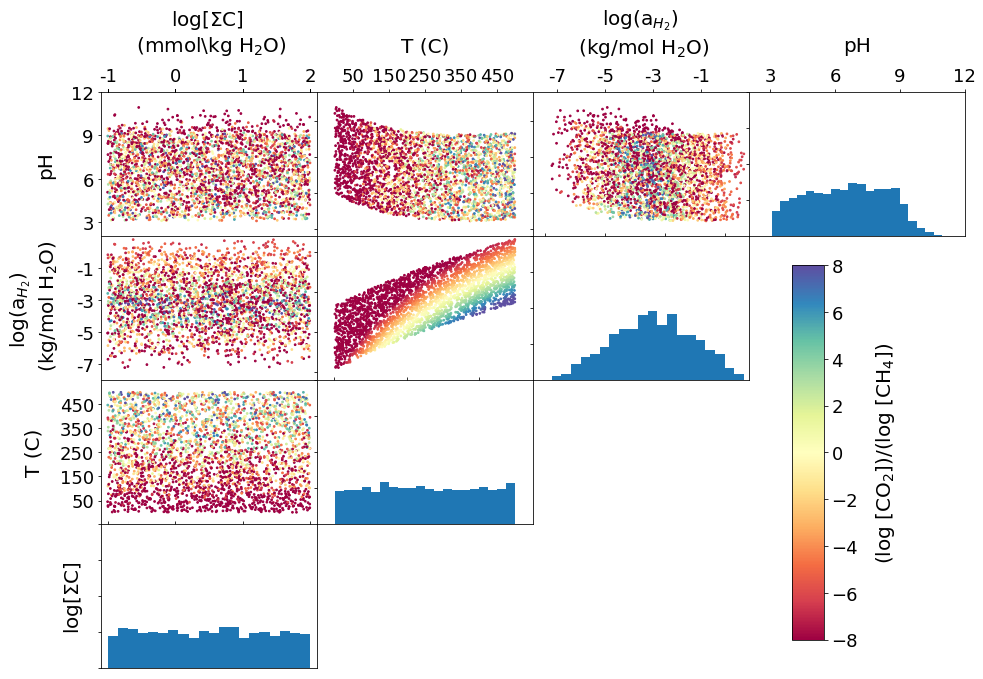

In [391]:
fig = plt.figure(2)

#First row
ax = plt.subplot(4,4,1)
#plt.plot(sigma_C, pH_rel, 'k.', markersize = 5.0)
plt.scatter(sigma_C, pH, s = 12.0, marker = '.', c = (np.log10(CO2/CH4)), cmap = 'Spectral')
plt.xlabel(labels[0])
plt.ylabel(labels[-1])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(C_ticks, C_labels)
plt.xlim(C_lim)
plt.yticks(pH_ticks, pH_labels)
plt.ylim(pH_lim)
plt.clim(-8,8)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

ax = plt.subplot(4,4,2)
#plt.plot(T, pH_rel, 'k.', markersize = 5.0)
plt.scatter(T, pH, s = 12.0, marker = '.', c = (np.log10(CO2/CH4)), cmap = 'Spectral')
plt.xlabel(labels[1])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(T_ticks, T_labels)
plt.xlim(T_lim)
plt.ylim(pH_lim)
plt.clim(-8,8)

ax = plt.subplot(4,4,3)
#plt.plot(aH2_rel, pH_rel, 'k.', markersize = 5.0)
plt.scatter(aH2, pH, s = 12.0, marker = '.', c = (np.log10(CO2/CH4)), cmap = 'Spectral')
plt.xlabel(labels[2])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(aH2_ticks, aH2_labels)
plt.xlim(aH2_lim)
plt.ylim(pH_lim)
plt.clim(-8,8)

ax = plt.subplot(4,4,4)
#plt.hist(pH_rel, bins = 10, weights=weight(pH))
plt.hist(pH, bins = 20, weights=weight(pH))
plt.xlabel(labels[3])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xlim(pH_lim)
plt.xticks(pH_ticks, pH_labels)
plt.ylim(0,0.2)

#Second Row
ax = plt.subplot(4,4,5)
#plt.plot(sigma_C, aH2_rel, 'k.', markersize = 5.0)
plt.scatter(sigma_C, aH2, s = 12.0, marker = '.', c = (np.log10(CO2/CH4)), cmap = 'Spectral')
plt.ylabel(labels[-2])
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(C_lim)
plt.yticks(aH2_ticks, aH2_labels)
plt.ylim(aH2_lim)
plt.clim(-8,8)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

ax = plt.subplot(4,4,6)
#plt.plot(T, aH2_rel, 'k.', markersize = 5.0)
plt.scatter(T, aH2, s = 12.0, marker = '.', c = (np.log10(CO2/CH4)), cmap = 'Spectral')
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(T_lim)
plt.ylim(aH2_lim)
plt.clim(-8,8)

ax = plt.subplot(4,4,7)
#plt.hist(aH2_rel, bins = 10, weights=weight(aH2))
plt.hist(aH2, bins = 20, weights=weight(aH2))
ax.xaxis.tick_top()
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(aH2_lim)
plt.ylim(0,0.2)

#Third Row
ax = plt.subplot(4,4,9)
plt.scatter(sigma_C, T, s = 12.0, marker = '.', c = (np.log10(CO2/CH4)), cmap = 'Spectral')
plt.ylabel(labels[-3])
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(C_lim)
plt.yticks(T_ticks, T_labels)
plt.ylim(T_lim)
plt.clim(-8,8)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

ax = plt.subplot(4,4,10)
plt.hist(T, bins = 20, weights=weight(T))
ax.xaxis.tick_top()
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(T_lim)
plt.ylim(0,0.2)

#Fourth Row
ax = plt.subplot(4,4,13)
plt.hist(sigma_C, bins = 20, weights=weight(sigma_C))
ax.xaxis.tick_top()
plt.ylabel('log[$\Sigma$C]')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.ylim(0,0.2)
plt.xlim(C_lim)

#Adjust spacing in subloglogs
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0.00, hspace=0.00)

left  = 0.125  # the left side xof the subloglogs of the figure
right = 0.9    # the right side of the subloglogs of the figure
bottom = 0.1   # the bottom of the subloglogs of the figure
top = 0.9      # the top of the subloglogs of the figure
wspace = 0.2   # the amount of width reserved for blank space between subloglogs
hspace = 0.5   # the amount of height reserved for white space between subloglogs

cbar_ax = fig.add_axes([1.6, 0.1, 0.075, 1.3])
plt.colorbar(cax = cbar_ax, label='(log [CO$_2$])/(log [CH$_4$])')
plt.savefig('Pyramids/(CO2toCH4).png', bbox_inches = 'tight')

In [385]:
np.min(np.log10(CO2/CH4))

-25.04069319600888

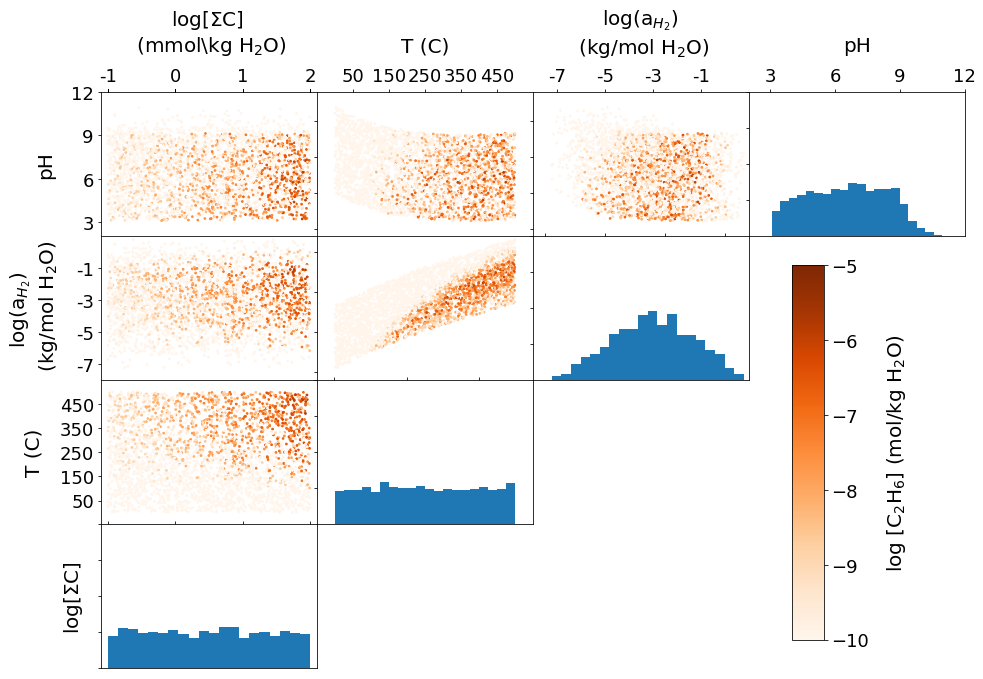

In [397]:
fig = plt.figure(2)

#First row
ax = plt.subplot(4,4,1)
#plt.plot(sigma_C, pH_rel, 'k.', markersize = 5.0)
plt.scatter(sigma_C, pH, s = 12.0, marker = '.', c = np.log10(HCOOH), cmap = 'Oranges')
plt.xlabel(labels[0])
plt.ylabel(labels[-1])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(C_ticks, C_labels)
plt.xlim(C_lim)
plt.yticks(pH_ticks, pH_labels)
plt.ylim(pH_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
plt.clim(-10,-5)

ax = plt.subplot(4,4,2)
#plt.plot(T, pH_rel, 'k.', markersize = 5.0)
plt.scatter(T, pH, s = 12.0, marker = '.', c = np.log10(HCOOH), cmap = 'Oranges')
plt.xlabel(labels[1])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(T_ticks, T_labels)
plt.xlim(T_lim)
plt.ylim(pH_lim)
plt.clim(-10,-5)

ax = plt.subplot(4,4,3)
#plt.plot(aH2_rel, pH_rel, 'k.', markersize = 5.0)
plt.scatter(aH2, pH, s = 12.0, marker = '.', c = np.log10(HCOOH), cmap = 'Oranges')
plt.xlabel(labels[2])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(aH2_ticks, aH2_labels)
plt.xlim(aH2_lim)
plt.ylim(pH_lim)
plt.clim(-10,-5)

ax = plt.subplot(4,4,4)
#plt.hist(pH_rel, bins = 10, weights=weight(pH))
plt.hist(pH, bins = 20, weights=weight(pH))
plt.xlabel(labels[3])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xlim(pH_lim)
plt.xticks(pH_ticks, pH_labels)
plt.ylim(0,0.2)

#Second Row
ax = plt.subplot(4,4,5)
#plt.plot(sigma_C, aH2_rel, 'k.', markersize = 5.0)
plt.scatter(sigma_C, aH2, s = 12.0, marker = '.', c = np.log10(HCOOH), cmap = 'Oranges')
plt.ylabel(labels[-2])
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(C_lim)
plt.yticks(aH2_ticks, aH2_labels)
plt.ylim(aH2_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
plt.clim(-10,-5)

ax = plt.subplot(4,4,6)
#plt.plot(T, aH2_rel, 'k.', markersize = 5.0)
plt.scatter(T, aH2, s = 12.0, marker = '.', c = np.log10(HCOOH), cmap = 'Oranges')
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(T_lim)
plt.ylim(aH2_lim)
plt.clim(-10,-5)

ax = plt.subplot(4,4,7)
#plt.hist(aH2_rel, bins = 10, weights=weight(aH2))
plt.hist(aH2, bins = 20, weights=weight(aH2))
ax.xaxis.tick_top()
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(aH2_lim)
plt.ylim(0,0.2)

#Third Row
ax = plt.subplot(4,4,9)
plt.scatter(sigma_C, T, s = 12.0, marker = '.', c = np.log10(HCOOH), cmap = 'Oranges')
plt.ylabel(labels[-3])
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(C_lim)
plt.yticks(T_ticks, T_labels)
plt.ylim(T_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
plt.clim(-10,-5)

ax = plt.subplot(4,4,10)
plt.hist(T, bins = 20, weights=weight(T))
ax.xaxis.tick_top()
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(T_lim)
plt.ylim(0,0.2)

#Fourth Row
ax = plt.subplot(4,4,13)
plt.hist(sigma_C, bins = 20, weights=weight(sigma_C))
ax.xaxis.tick_top()
plt.ylabel('log[$\Sigma$C]')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.ylim(0,0.2)
plt.xlim(C_lim)

#Adjust spacing in subloglogs
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0.00, hspace=0.00)

left  = 0.125  # the left side xof the subloglogs of the figure
right = 0.9    # the right side of the subloglogs of the figure
bottom = 0.1   # the bottom of the subloglogs of the figure
top = 0.9      # the top of the subloglogs of the figure
wspace = 0.2   # the amount of width reserved for blank space between subloglogs
hspace = 0.5   # the amount of height reserved for white space between subloglogs

cbar_ax = fig.add_axes([1.6, 0.1, 0.075, 1.3])
plt.colorbar(cax = cbar_ax, label='log [C$_2$H$_6$] (mol/kg H$_2$O)')
plt.savefig('Pyramids/(HCOOH).png', bbox_inches = 'tight')

In [395]:
np.max(np.log10(HCOOH))

-5.836839005514217

In [275]:
# #Now let's try sorting models by their oxidation state:
# #Since values are chosen at random, we need to define some range about FMQ in which models are closer to FMQ than anything else

# #function to convert celcius to kelvin
def C_to_K(T_C):
    T_K = T_C+273.15
    return T_K

#We already have FMQ from earlier

#For converting fO2s to aH2s
num, T_convert, P, logK_fO2toaH2 = np.loadtxt('Europa_K/meteorite_fO2toaH2.txt', skiprows=8, max_rows=501, unpack=True)

#PPM:
num, T_PPM, P, logK_PPM = np.loadtxt('Europa_K/PPM_fO2.txt', skiprows=9, max_rows=501, unpack=True)
fO2_PPM = -logK_PPM
aH2_PPM = 0.5*(-logK_fO2toaH2 - fO2_PPM)

#Schaefer & Fegley:
def met_fit(T, a,b,c,d,f):
    fO2 = a + (b*(1e3)/T) + (c*(1e6)/(T**2)) + (d*(1e9)/(T**3)) + (f*(1e12)/(T**4))
    return fO2

#Constants from paper: CI, CV, H, EH, Euc
a = np.array([2.4976, 9.0621, 5.0743, 4.9495, 5.4856])
b = np.array([-9.8605, -31.193, -22.906, -24.024, -25.127])
c = np.array([-17.0701, 5.1092, -5.6610, -4.6236, -3.6580])
d = np.array([7.5220, -1.8475, 2.0634, 1.7177, 1.3014])
f = np.array([-1.0404, 0.2000, -0.2618, -0.2332, -0.1650])

fO2_CI = met_fit(C_to_K(T_PPM),a[0],b[0],c[0],d[0],f[0])
fO2_CV = met_fit(C_to_K(T_PPM),a[1],b[1],c[1],d[1],f[1])
fO2_H = met_fit(C_to_K(T_PPM),a[2],b[2],c[2],d[2],f[2])
fO2_EH = met_fit(C_to_K(T_PPM),a[3],b[3],c[3],d[3],f[3])
fO2_Euc = met_fit(C_to_K(T_PPM),a[4],b[4],c[4],d[4],f[4])

#Convert these to aH2: O2(g) + 2H2(aq) -> 2H2O(liq)
#K = -2(fH2) - fO2 -> fH2 = 0.5*(-K - fO2) (1500 bar)
#N, T, P, logK_aH2 = np.loadtxt('Europa_K/meteorite_aH2.txt', skiprows=8, unpack=True)
aH2_CI = 0.5*(-logK_fO2toaH2 - fO2_CI)
aH2_CV = 0.5*(-logK_fO2toaH2 - fO2_CV)
aH2_H = 0.5*(-logK_fO2toaH2 - fO2_H)
aH2_EH = 0.5*(-logK_fO2toaH2 - fO2_EH)
aH2_Euc = 0.5*(-logK_fO2toaH2 - fO2_Euc)

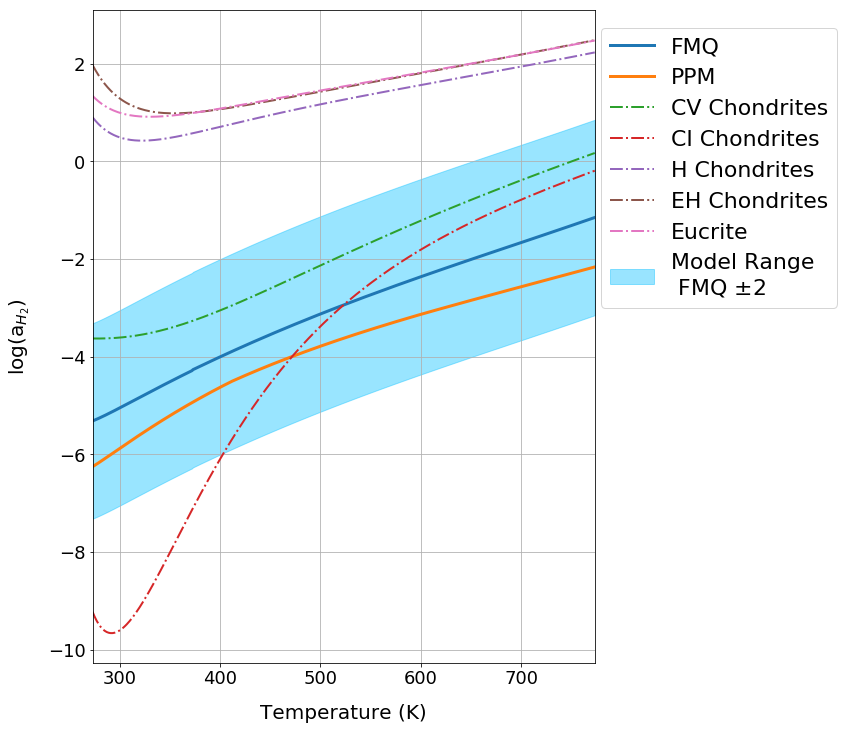

In [276]:
fig5 = plt.figure(5)
fig5.set_figheight(12)
fig5.set_figwidth(9)
plt.clf()
#plt.plot(T, fO2[0], 'b')
plt.fill_between(C_to_K(T_FMQ), (aH2_FMQ-2), (aH2_FMQ+2), alpha = 0.4, color = 'deepskyblue', label = 'Model Range\n FMQ $\pm 2$')
#plt.plot(C_to_K(T), aH2_FMQp, linewidth = 3, label = 'FMQ (1 bar)')
#plt.plot(C_to_K(T_ppm), aH2_PPMp, linewidth = 3, label = 'PPM (1 bar)')
plt.plot(C_to_K(T_FMQ), aH2_FMQ, linewidth = 3, label = 'FMQ')
#plt.plot(C_to_K(T_FMQ), aH2_FMQ+0.15, linewidth = 3, label = 'cutoff')
plt.plot(C_to_K(T_PPM), aH2_PPM, linewidth = 3, label = 'PPM')
plt.plot(C_to_K(T_convert), aH2_CV, '-.', markevery=10, linewidth = 2, label = 'CV Chondrites')
plt.plot(C_to_K(T_convert), aH2_CI, '-.', markevery=10, linewidth = 2, label = 'CI Chondrites')
plt.plot(C_to_K(T_convert), aH2_H, '-.', markevery=10, linewidth = 2, label = 'H Chondrites')
plt.plot(C_to_K(T_convert), aH2_EH, '-.', markevery=10, linewidth = 2, label = 'EH Chondrites')
plt.plot(C_to_K(T_convert), aH2_Euc, '-.', markevery=10, linewidth = 2, label = 'Eucrite')
#plt.plot(T, fO2[2], 'b')
plt.xlabel('Temperature (K)')
plt.ylabel(r'log(a$_{H_2}$)')
plt.xlim(273.16, 773.15)
plt.grid()
plt.legend(bbox_to_anchor=(0.99,0.99), prop={'size': 22})
plt.savefig('Pyramids/OxState_Refs.png', bbox_inches = 'tight')
plt.show()


In [289]:
#Arbitrarily choose a 'cutoff' point to assign models to their closest analog ox state
cut = 0.15 #log units about reference point

FMQ_models = []
PPM_models = []
CV_models = []
CI_models = []

for temp in range(0,len(T_FMQ)): #temps between 0 and 500
    indices = np.where(T == T_FMQ[temp]) #choose only models at a given temp
    for i in np.nditer(indices):
        if  aH2_FMQ[temp] - cut <= aH2[i] <= aH2_FMQ[temp] + cut:
            FMQ_models.append(i)

ValueError: Iteration of zero-sized operands is not enabled